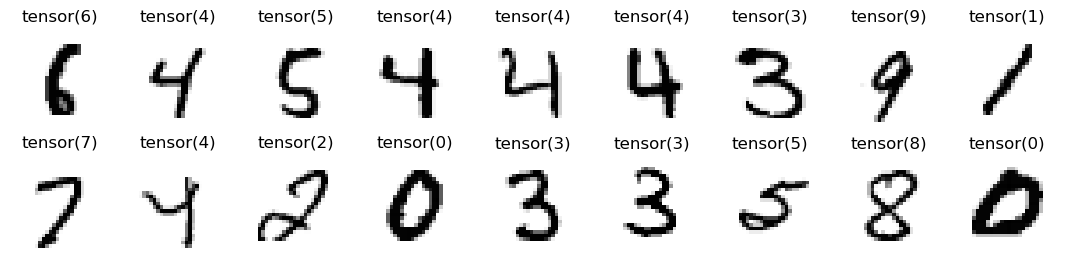

In [1]:
import torchvision
import torch
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

trans = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(
    root="./MNIST", train=True, transform=trans, download=False)
test_data  = torchvision.datasets.MNIST(
    root="./MNIST", train=False, transform=trans, download=False)

BATCH_SIZE = 256  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = BATCH_SIZE)

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(label[i])
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
show_img(x,y,2,9)

In [2]:
class model(torch.nn.Module):
    def __init__(self,in_dims,out_dim):
        super().__init__()
        self.layers = torch.nn.modules.Sequential(
            torch.nn.Linear(in_dims,out_dim),
        )
    def forward(self,x):
        x = self.layers(x)
        return x

In [3]:
def softmax(x):
    x_exp = torch.exp(x)
    x_exp_sum = x_exp.sum(1,keepdims=True)
    return x_exp/x_exp_sum

def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

def accuracy(y_hat,y):
    pred = y_hat.argmax(1)
    cmp = pred==y
    print("Accuracy:%.3f"%(cmp.sum()/len(y)))

# aa = torch.tensor([[0.1,0.2],[0.1,0.2]])
# bb = torch.tensor([1,1])
# accuracy(aa,bb)

# y = torch.tensor([0,2])
# y_hat = torch.tensor([[0.1,0.2,0.7],[0.2,0.4,0.4]])
# print(y_hat[[0,1,],y])
# print(cross_entropy(y_hat,y))

In [4]:
# w = torch.normal(0,1,(28*28,10),requires_grad=True)
# b = torch.normal(0,1,(10,),requires_grad=True)
w = torch.zeros((28*28,10),requires_grad=True)
b = torch.zeros((10,),requires_grad=True)

In [5]:
n_epoch = 3
optimizer = torch.optim.SGD([w,b],0.001)
for epoch in range(n_epoch):
    for img,label in train_dataloader:
        img = img.flatten(1)
        y_hat = torch.matmul(img,w)+b
        y_hat = softmax(y_hat)
        loss = cross_entropy(y_hat,label)
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
    for img,label in test_dataloader:
        img = img.flatten(1)
        y_hat = torch.matmul(img,w)+b
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        break
        

Accuracy:0.934
Accuracy:0.941
Accuracy:0.945


In [6]:
n_epoch = 3
my_model = model(28*28,10)
optimizer = torch.optim.SGD(my_model.parameters(),0.001)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [7]:
for epoch in range(n_epoch):
    my_model.train()
    for img,label in train_dataloader:
        img = img.flatten(1)
        pred = my_model(img)
        loss = criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    my_model.eval()
    calcu_acc = []
    for img, label in test_dataloader:
        with torch.no_grad():
            img = img.flatten(1)
            pred = my_model(img)
            pred = pred.softmax(1)
            accuracy(pred,label)
            break 
     

Accuracy:0.934
Accuracy:0.941
Accuracy:0.945


Accuracy:0.910


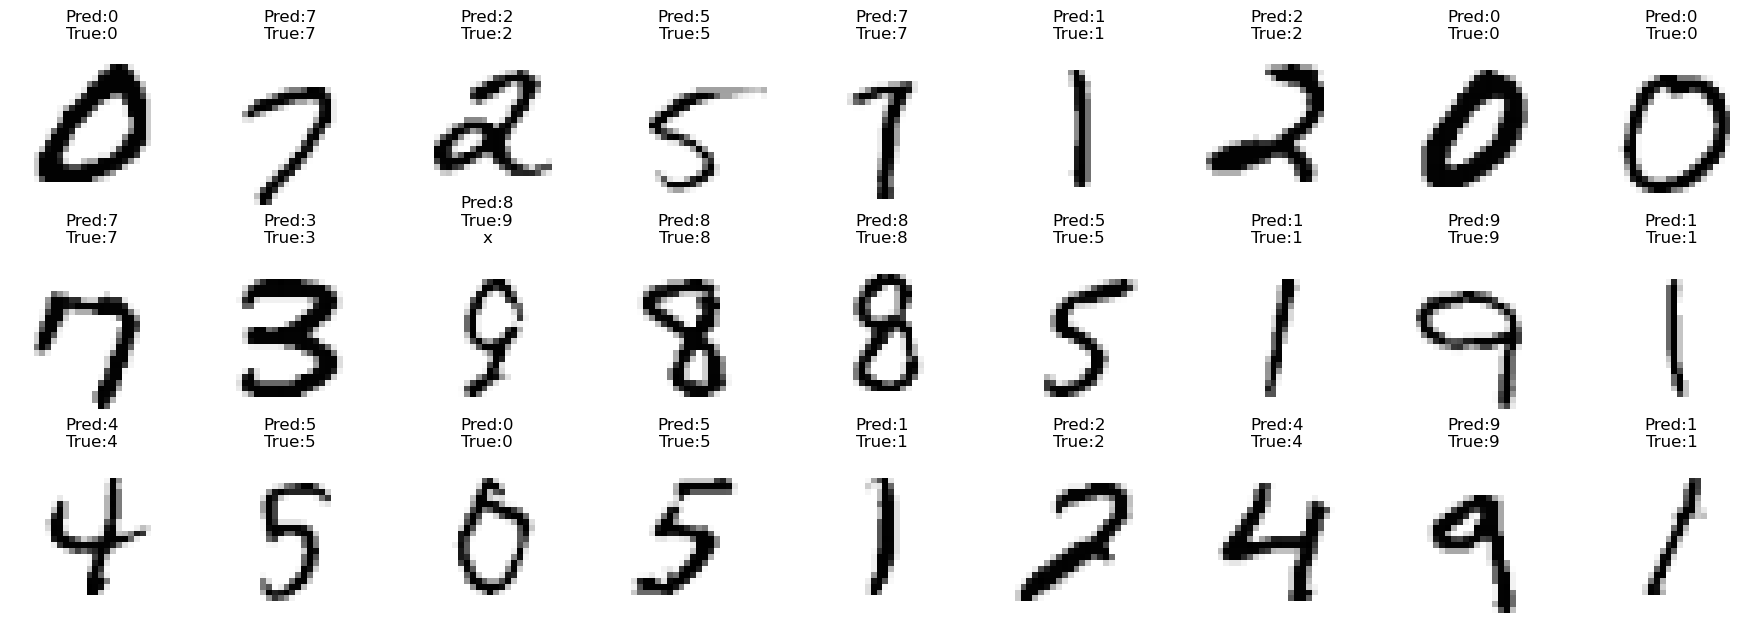

In [8]:
def pred_img(count): # using manual configuration to build model and predict the answer
    for img,label in train_dataloader:
        img_flatten = img.flatten(1)
        y_hat = torch.matmul(img_flatten,w)+b
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        pred  = y_hat.argmax(1)
        title = ['Pred:' + str(int(i)) + '\nTrue:' + str(int(j)) + ('\nx' if int(i)!=int(j) else '') for i,j in zip(pred,label)]
        show_img(img,title,3,9,scale=2.5)
        count-=1
        if count == 0:
            return

pred_img(1)

Accuracy:0.934


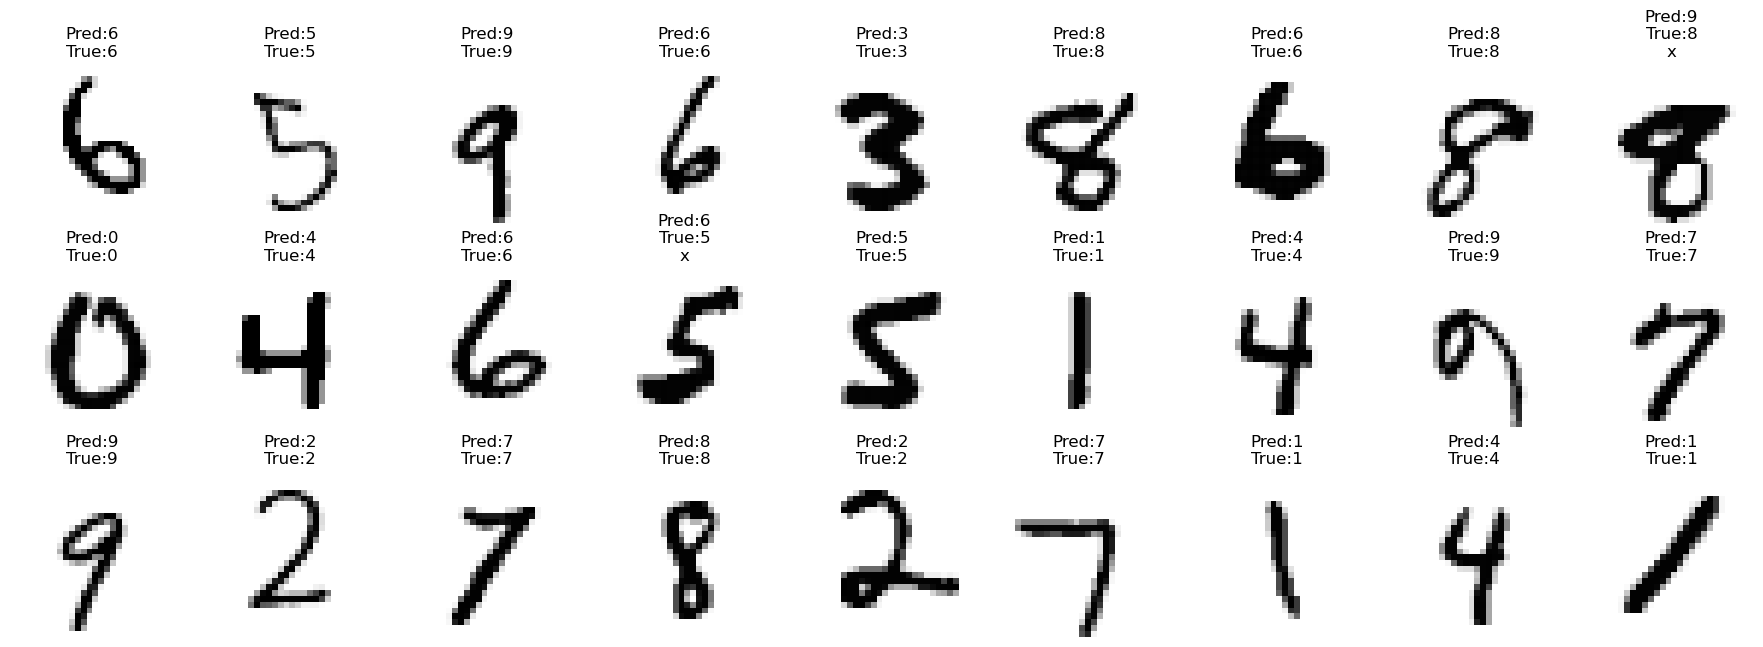

In [9]:
def pred_img(count): # using pytorch to build model and predict the answer
    for img,label in train_dataloader:
        my_model.eval()
        img_flatten = img.flatten(1)
        y_hat = my_model(img_flatten)
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        pred  = y_hat.argmax(1)
        title = ['Pred:' + str(int(i)) + '\nTrue:' + str(int(j)) + ('\nx' if int(i)!=int(j) else '') for i,j in zip(pred,label)]
        show_img(img,title,3,9,scale=2.5)
        count-=1
        if count == 0:
            return

pred_img(1)